# Social Reinforcement Learning Second Level Analyses

## Set Up

### Import packages

In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np

from matplotlib.gridspec import GridSpec

# Import cerebellum packages
import matplotlib.pyplot as plt
import SUITPy.flatmap as flatmap

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img, cluster_level_inference

import importlib
import helpful_functions
importlib.reload(helpful_functions)



<module 'helpful_functions' from '/Users/hpopal/Library/CloudStorage/GoogleDrive-hpopal@umd.edu/My Drive/dscn_lab/projects/scon_social_reward/code/neuron_code/helpful_functions.py'>

### Set directories and import subject data

In [2]:
#bids_dir = '/data/neuron/SCN/SR/'
bids_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'

os.chdir(bids_dir)

data_dir = os.path.join(bids_dir, 'derivatives','rl_modeling','subject_results')
outp_dir = data_dir+'group/'

# Import scan info for runs that passed QC
subjs_scan_info = pd.read_csv(bids_dir+'/derivatives/participants-qc-min_task_errors.csv')

# Create a participant list for only those with good scans
subjs_list = list(subjs_scan_info['participant_id'].unique())
subjs_list.sort()

# Import other participant info like demographics
subjs_info = pd.read_csv(bids_dir+'/participants.tsv', sep='\t', index_col=0)
#subjs_info = subjs_info.rename(columns={'participant_id': 'subject_label'})

# Filter for only participants with good scan data
#subjs_info = subjs_info.loc[subjs_list]
subjs_info = subjs_info[subjs_info.index.isin(subjs_list)]

# Rename group IDs
subjs_info['group'] = subjs_info['group'].map({1: 'not_asd', 2: 'asd'})

# Reset index to make participant IDs a column
subjs_info = subjs_info.reset_index()


subjs_info_typ = subjs_info[subjs_info['group']=='not_asd']
subjs_info_asd = subjs_info[subjs_info['group']=='asd']

#subjs_list = subjs_info.index.to_list()
subjs_list_typ = subjs_info_typ['participant_id'].to_list()
subjs_list_asd = subjs_info_asd['participant_id'].to_list()

print('Found '+str(len(subjs_list_typ))+' non-autistic participants')
print('Found '+str(len(subjs_list_asd))+' autistic participants')

Found 85 non-autistic participants
Found 28 autistic participants


## Non-Autistic Adolescents

<Axes: label='conditions', ylabel='scan number'>

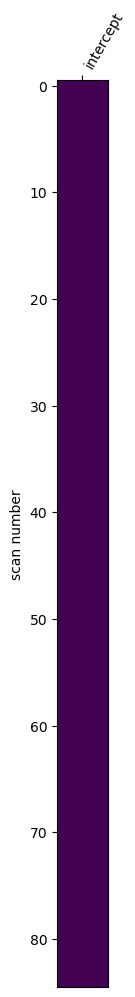

In [3]:
design_matrix = make_second_level_design_matrix(subjs_list_typ)

plot_design_matrix(design_matrix)

In [4]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['RPE','RPE_abs','RvL']
group = 'not_asd'
tasks = ['SR']
alpha = 0.005
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list_typ.copy()
        temp_file_list = []
        for subj in subjs_list_typ:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating group '+contrast+' contrast')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
        z_map_thresh.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
        #z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
        #                           'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
        threshold_data[group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold
        

Calculating group RPE contrast
Calculating group RPE_abs contrast
Calculating group RvL contrast


### Proof of Concept: Button Press
This is a contrast of button presses vs fixation just to see if we get the motor cortex as would be expected.

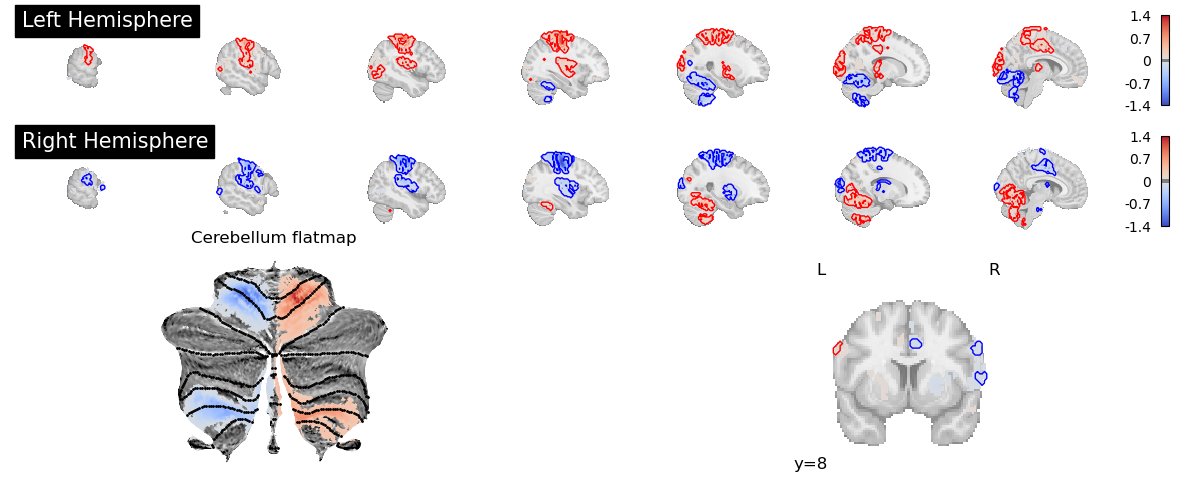

In [4]:
filename = data_dir+'/../group_results/'+'not_asd_SR_RvL'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

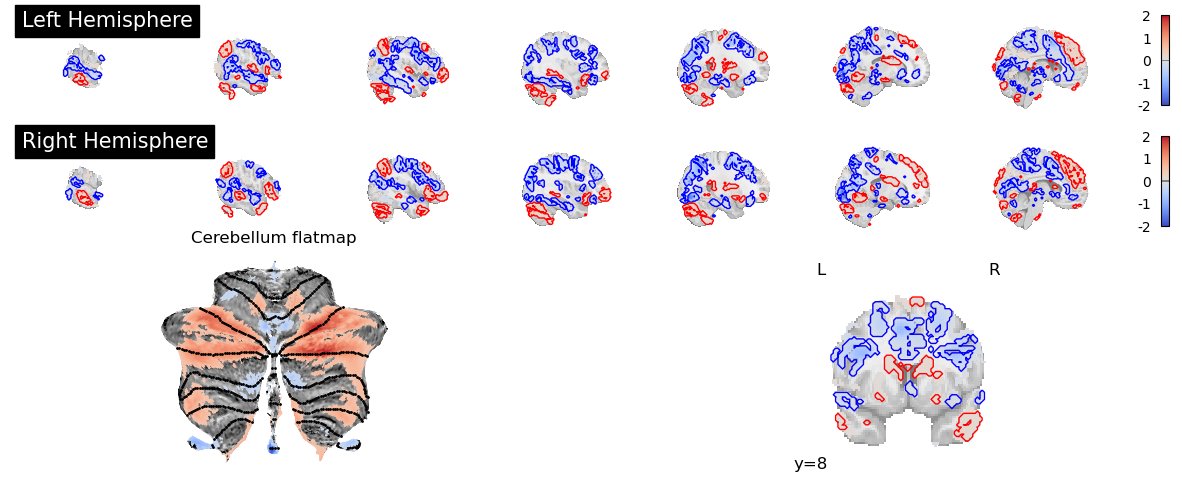

In [5]:
filename = data_dir+'/../group_results/'+'not_asd_SR_ButtonPress'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

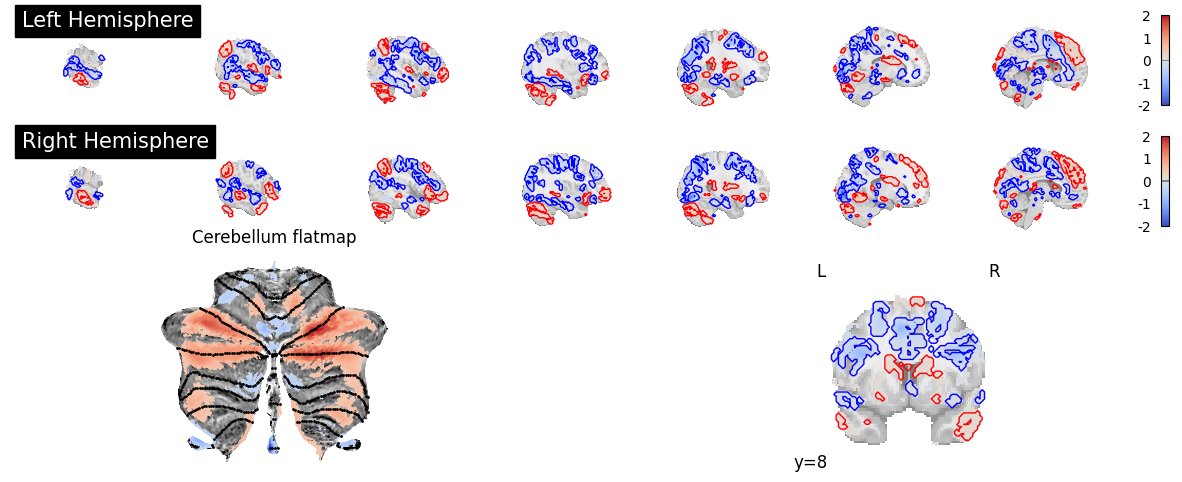

In [5]:
filename = data_dir+'/group/'+'not_asd_SR_ButtonPress'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

Opposite results than expected. Greater activation during fixation in motor and visual regions and greater activation in social regions for button presses. Need to double check the regresssors for this analysis.

### Reward Prediction Error
Reward prediction error as calculate from a Resola-Wagner model. Positive activation means more reward than expected, and negative reward means less reward than expected.

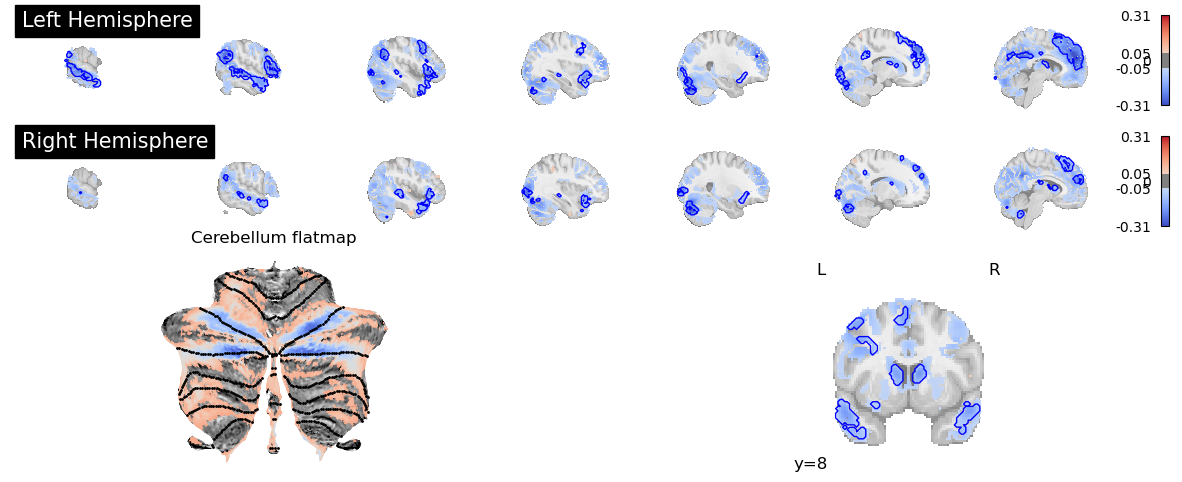

In [6]:
filename = data_dir+'/../group_results/'+'not_asd_SR_RPE'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


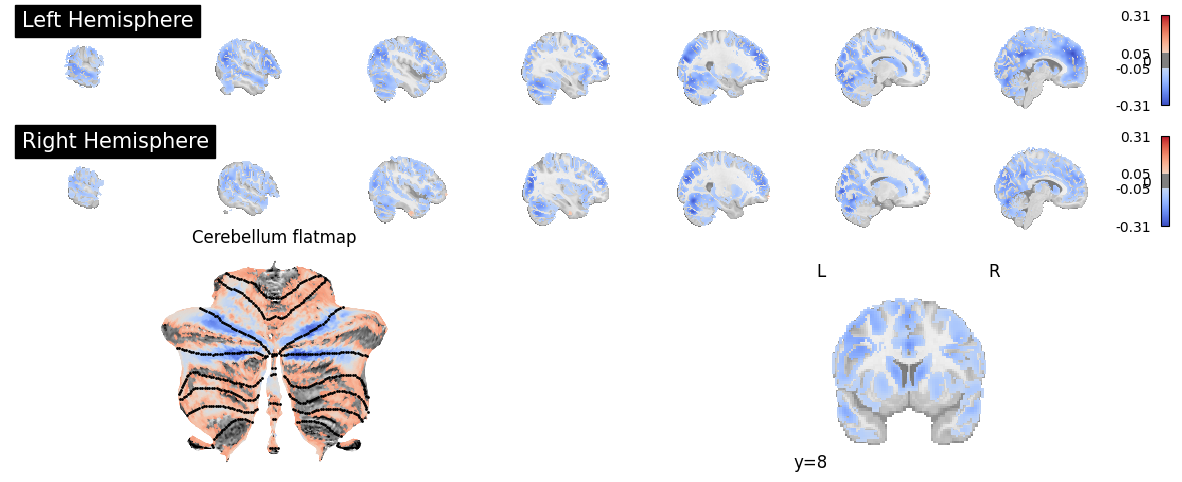

In [6]:
filename = data_dir+'/group/'+'not_asd_SR_RPE'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

No Significant results. Need to look at this more because it is weird that results are strongest in the sulci and near the midline.

### Absolute Reward Prediction Error
This regressor represents the absolute value of the reward prediction error. Positive activations represent greater resposne when the error is greater, regardless of whether the signal is positive or negative.

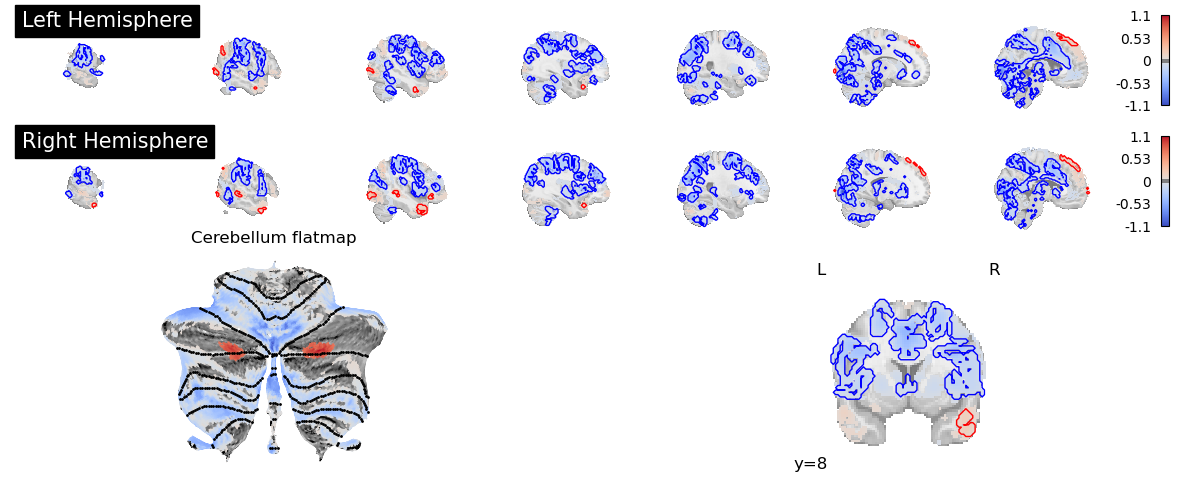

In [7]:
filename = data_dir+'/../group_results/'+'not_asd_SR_RPE_abs'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

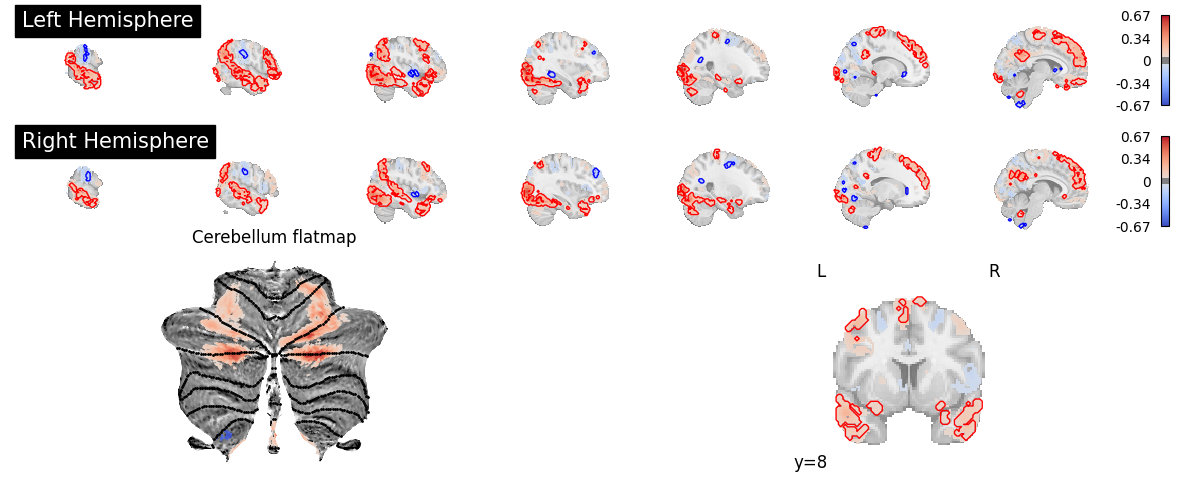

In [7]:
filename = data_dir+'/group/'+'not_asd_SR_RPE_abs'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

Lots of DMN regions including the mPFC, ATL, PCC, dlPFC, STS, visual cortex, and medial Crus I/II. Notably absent is the ventral striatum.

**Haroon's interpretation**: The cerebellum cares about the magnitude of errors and not their valence. It provides this information to the cortex.

## Autistic Adolescents

<Axes: label='conditions', ylabel='scan number'>

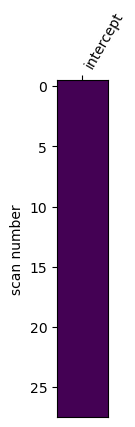

In [17]:
design_matrix = make_second_level_design_matrix(subjs_list_asd)

plot_design_matrix(design_matrix)

In [18]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['RPE','RPE_abs','ButtonPress']
group = 'asd'
tasks = ['SR']
alpha = 0.005
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list_asd.copy()
        temp_file_list = []
        for subj in subjs_list_asd:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating group '+contrast+' contrast')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        
        z_map_thresh.to_filename(os.path.join(data_dir,'../group_results',
                                   group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
            
        threshold_data[group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold

Calculating group RPE contrast


/opt/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 4.6794636856674385. But, you have given threshold=inf.
  stat_img = threshold_img(


Calculating group RPE_abs contrast
Calculating group ButtonPress contrast


### Proof of Concept: Button Press

In [9]:
filename = data_dir+'/../group_results/'+'asd_SR_RvL'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

File /Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/derivatives/rl_modeling/subject_results/../group_results/asd_SR_RvL_effect.nii.gz could not be opened


SystemExit: Error: None of the images could be opened.

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


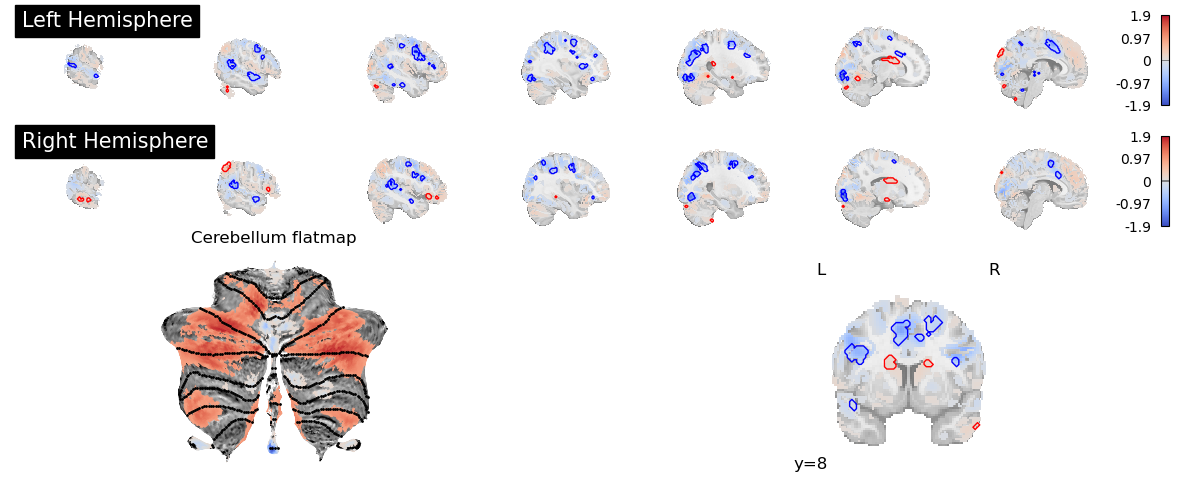

In [8]:
filename = data_dir+'/../group_results/'+'asd_SR_ButtonPress'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

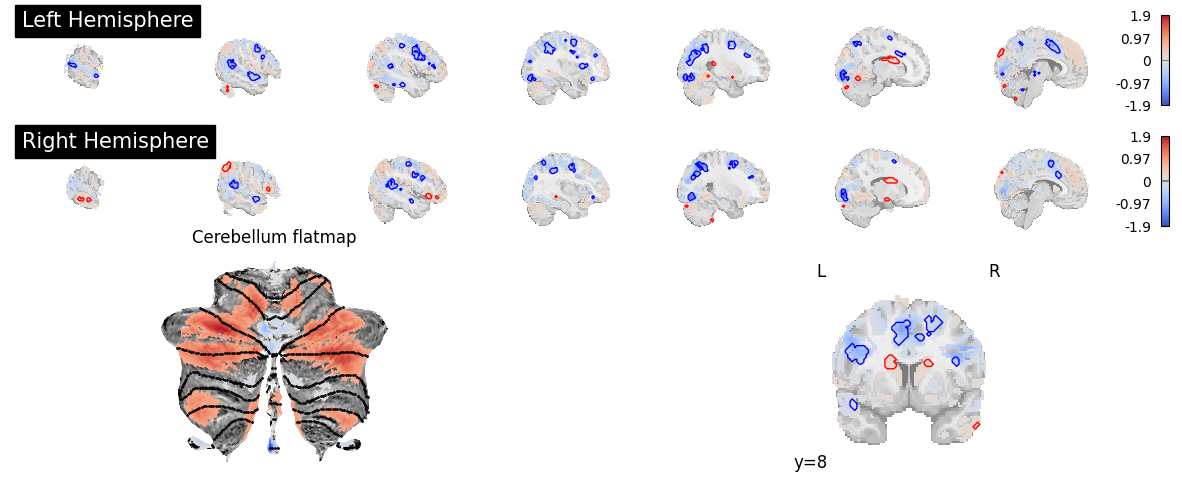

In [10]:
filename = data_dir+'/group/'+'asd_SR_ButtonPress'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

Again, these results are not as expected. 

### Reward Prediction Error

/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


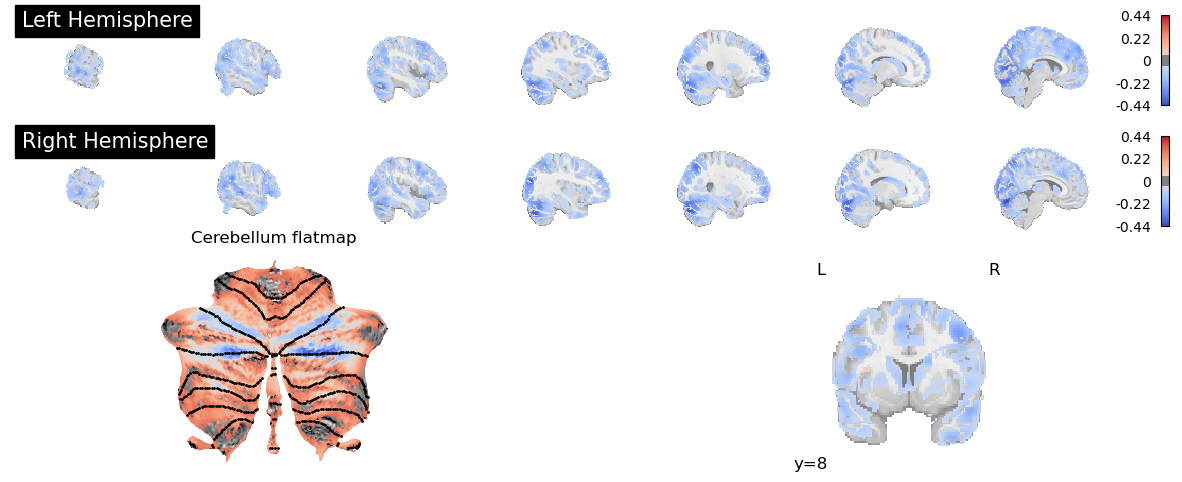

In [10]:
filename = data_dir+'/../group_results/'+'asd_SR_RPE'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


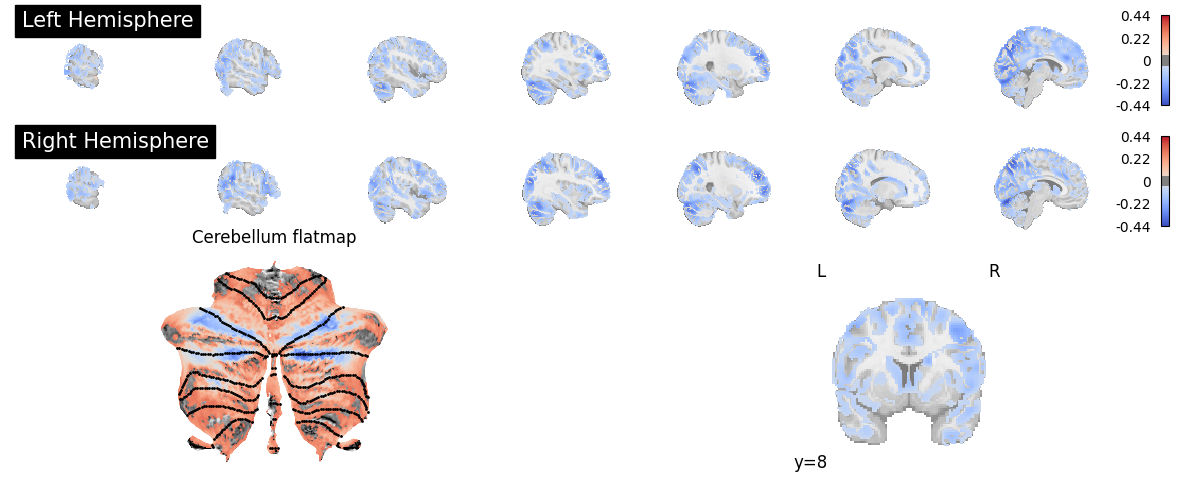

In [11]:
filename = data_dir+'/group/'+'asd_SR_RPE'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

Again, these results look off. 

### Absolute Reward Prediction Error

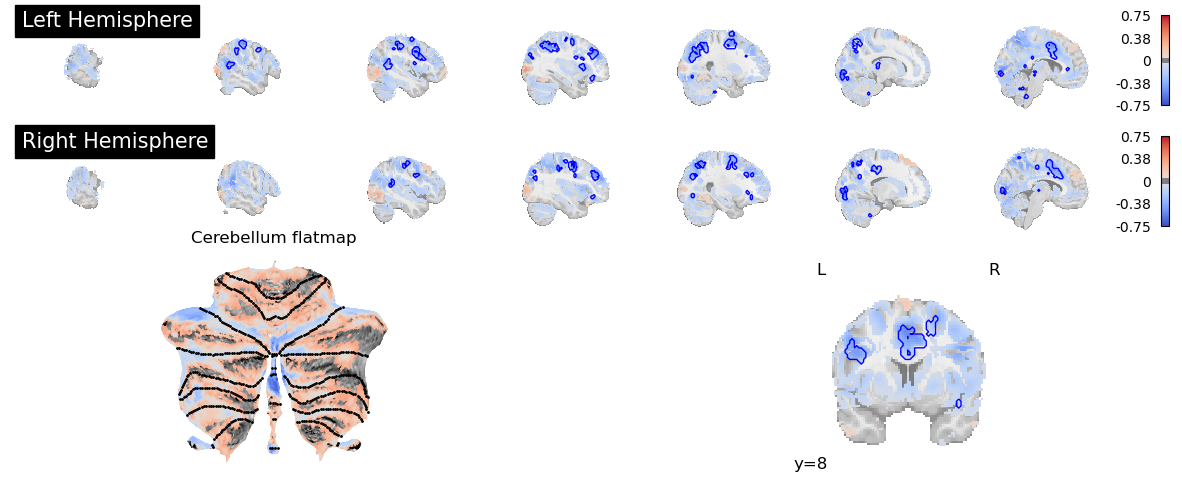

In [11]:
filename = data_dir+'/../group_results/'+'asd_SR_RPE_abs'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

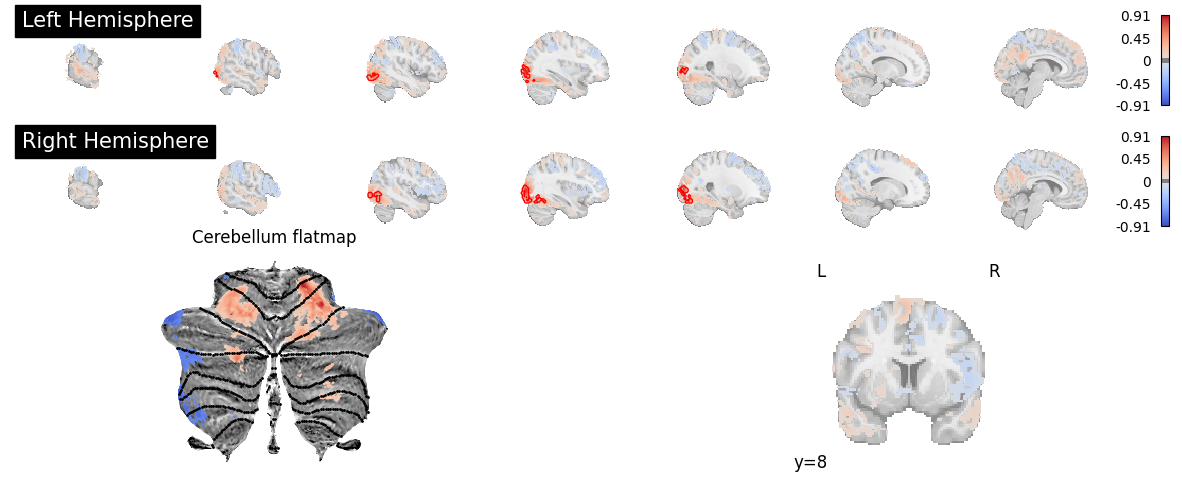

In [12]:
filename = data_dir+'/group/'+'asd_SR_RPE_abs'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

Significant error signals in the visual cortex. This doesn't make sense.

## All Subjects

/var/folders/pw/tzgkm76n1_lbwg6hwj8mkbw80000gq/T/ipykernel_8616/1405823549.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  subjs_info_num = subjs_info_num.replace({'group': {'asd': -1, 'not_asd': 1}})


<Axes: label='conditions', ylabel='scan number'>

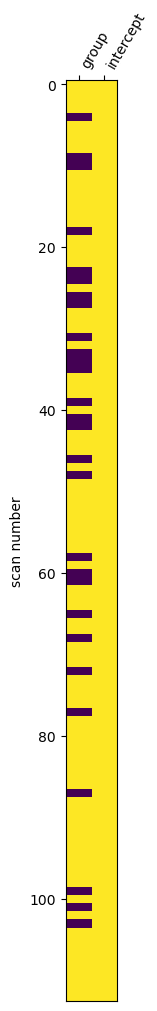

In [22]:
subjs_info_num = subjs_info.copy()
subjs_info_num = subjs_info_num.replace({'group': {'asd': -1, 'not_asd': 1}})
subjs_info_num = subjs_info_num.rename({'participant_id': 'subject_label'}, axis='columns')

# Drop irrelevant columns
subjs_info_num = subjs_info_num.drop(columns=['age','gender'])

design_matrix = make_second_level_design_matrix(subjs_list, subjs_info_num)

plot_design_matrix(design_matrix)

In [23]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['RPE','RPE_abs','ButtonPress']
contrasts_2nd = ['intercept', 'group']
group = 'all'
tasks = ['SR']
alpha = 0.05
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list.copy()
        temp_file_list = []
        for subj in subjs_list:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        # Filter subjs info data frame for only participants that have data
        temp_subjs_info_num = subjs_info_num[subjs_info_num['subject_label'].isin(temp_subj_list)]
        
        print('Calculating group '+contrast+' contrast for '+str(len(temp_file_list))+' subjects')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list, 
                                                        temp_subjs_info_num)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        for contrast_2nd in contrasts_2nd:
            contrast_stats = model.compute_contrast(contrast_2nd, output_type='all')
            z_map = contrast_stats['z_score']
            e_map = contrast_stats['effect_size']

            z_map.to_filename(os.path.join(data_dir,'../group_results',
                              group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_zmap.nii.gz'))
            e_map.to_filename(os.path.join(data_dir,'../group_results',
                              group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_effect.nii.gz'))
            
            # Multiple Comparisons Correction
            z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

            z_map_thresh.to_filename(os.path.join(data_dir,'../group_results',
                                       group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))

            threshold_data[group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_zmap_'+mc+'-'+str(alpha)] = threshold

Calculating group RPE contrast for 108 subjects


/opt/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 3.917200985084336. But, you have given threshold=inf.
  stat_img = threshold_img(


Calculating group RPE_abs contrast for 108 subjects


/opt/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 3.5901207764237446. But, you have given threshold=inf.
  stat_img = threshold_img(


Calculating group ButtonPress contrast for 88 subjects


/opt/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 4.7683513859091935. But, you have given threshold=inf.
  stat_img = threshold_img(


### Group Differences

#### Reward Prediction Error

/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


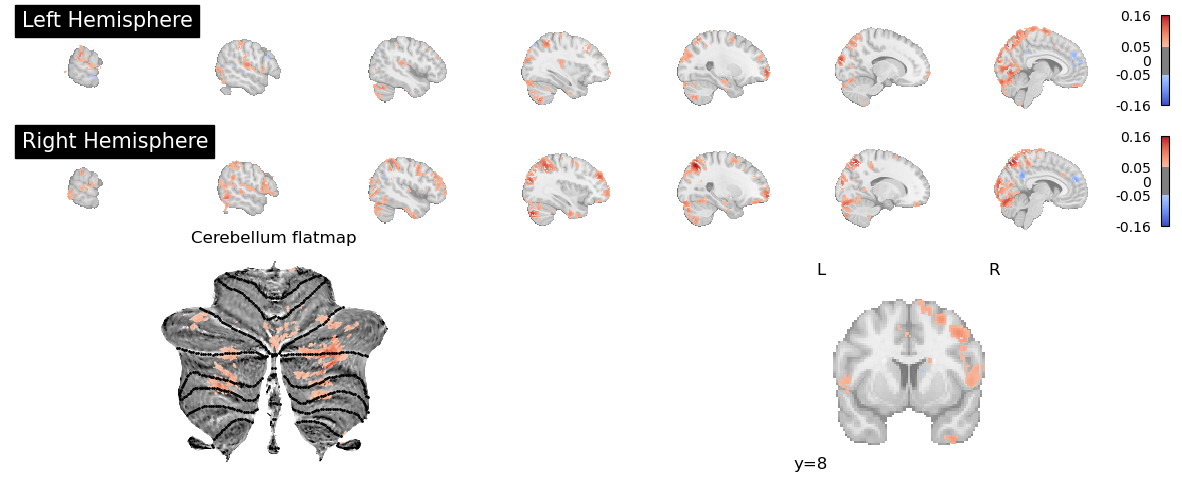

In [12]:
filename = data_dir+'/../group_results/'+'all_SR_RPE_group'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


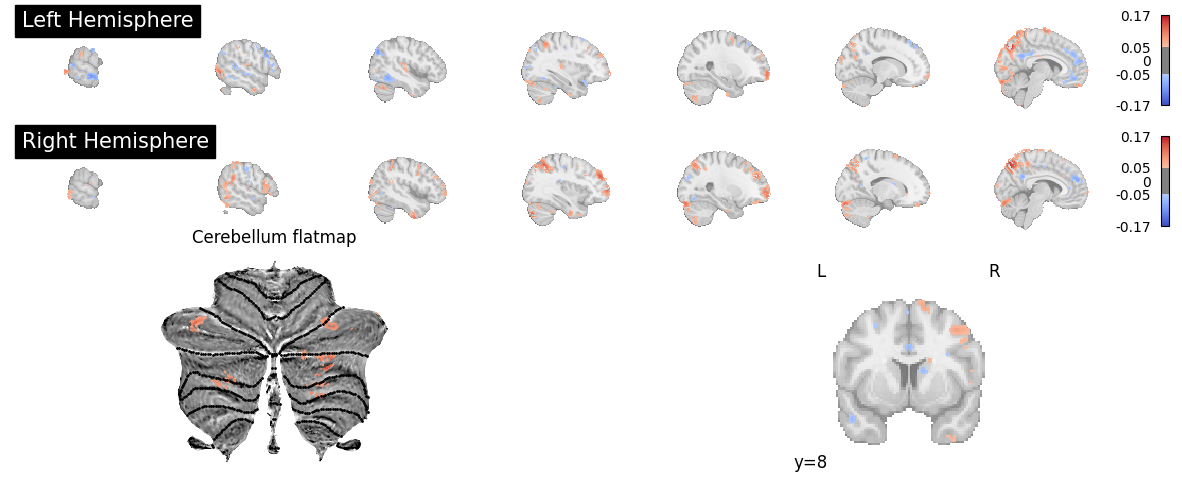

In [15]:
filename = data_dir+'/group/'+'all_SR_RPE_group'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

No significant results

#### Absolute Reward Prediction Error

/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


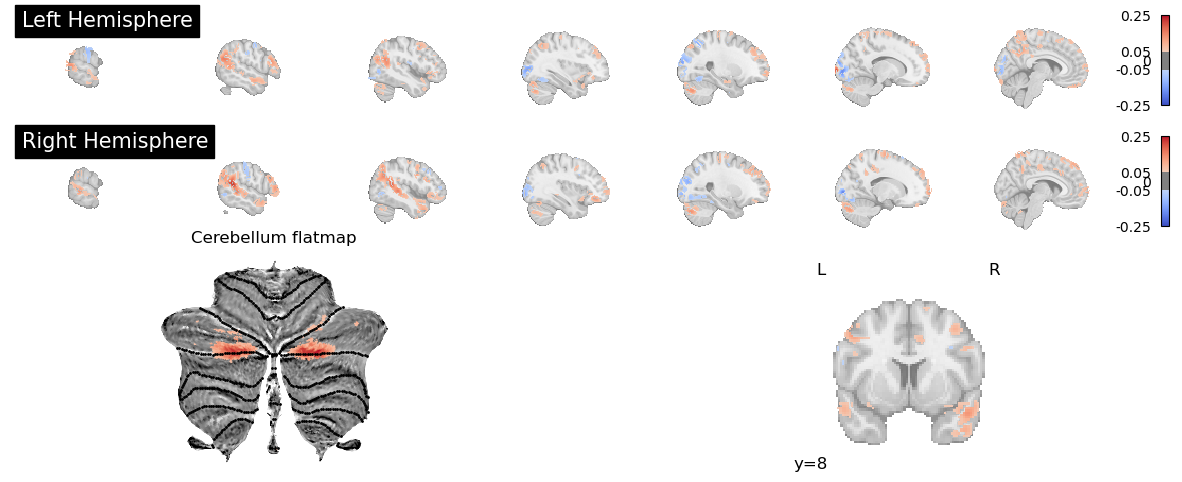

In [13]:
filename = data_dir+'/../group_results/'+'all_SR_RPE_abs_group'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


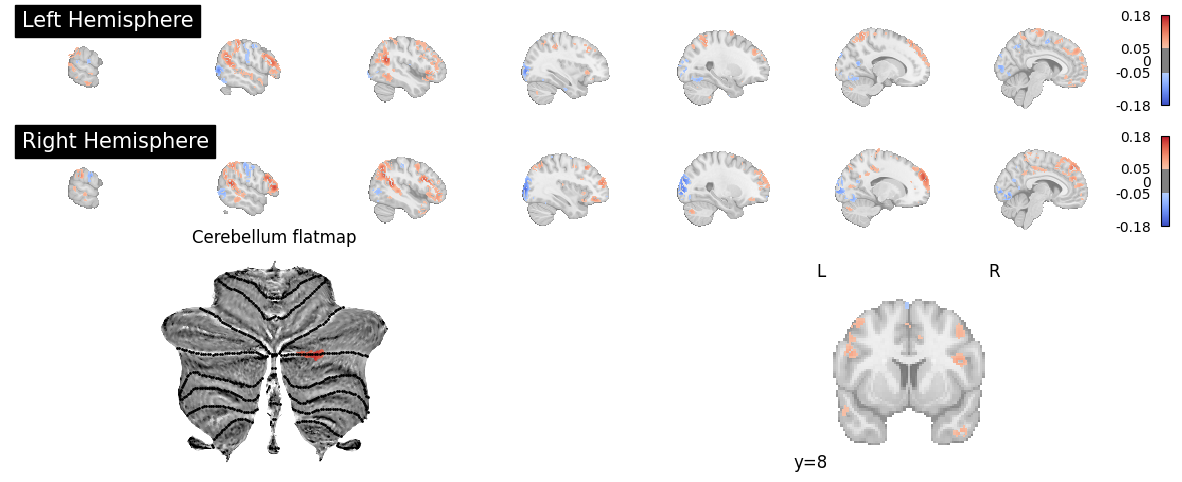

In [16]:
filename = data_dir+'/group/'+'all_SR_RPE_abs_group'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

No significant results.